In [1]:
# -*- coding: utf-8 -*-
"""
2018-06-28,29

Blinker analysis: PL intensity versus laser power
PL intensity versus laser power, QE 4-22-2018.11,00am

@author: Viva Horowitz
"""

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import seaborn as sns
import numpy as np
import sys
sys.path.append(r'C:\Users\Viva\Documents')
sys.path.append(r'C:\Users\Viva\Documents\detect_peaks.py')
import detect_peaks
## http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
from detect_peaks import detect_peaks


sns.set(style='ticks')
sns.set_context('poster')

%pylab inline
from matplotlib.mlab import frange

# ** set for each dataset
datadate = '2018-06-01'
datafolder = r'O:\User\Viva\data\2018-06-01_blinking-statistics\4-22-2018.11,00am'
analysisfolder = r'C:\Users\Viva\Documents\analysis\blinker_analysis\power_dependence,QE4-22-2018.11,00am'
filenames = ['4-22-2018.11,00am, 03, ND2,4.txt',
             '4-22-2018.11,00am, 04, ND2,3.txt',
             '4-22-2018.11,00am, 05, ND2,2.txt',
             '4-22-2018.11,00am, 06, ND2,0.txt',
             '4-22-2018.11,00am, 07, ND1,6.txt',
             '4-22-2018.11,00am, 08, ND1,5.txt',
             '4-22-2018.11,00am, 11, ND1,4.txt',
             '4-22-2018.11,00am, 12, ND1,3.txt',
             '4-22-2018.11,00am, 13, ND1,2.txt',
             '4-22-2018.11,00am, 14, ND1,0.txt']   
dataname = 'QE 4-22-2018.11,00am'
NDlist = [2.4, 2.3, 2.2, 2.0, 1.6, 1.5, 1.4, 1.3, 1.2, 1.0]

print(np.__version__)
print(sns.__version__)
print(pd.__version__)
print(mpl.__version__)

Populating the interactive namespace from numpy and matplotlib
1.10.4
0.8.0
0.20.3
2.1.0


In [2]:
os.chdir(r'O:\User\Viva')
filterwheel = pd.read_csv('Josh_filter_wheel.csv')

In [3]:
# Does not display all digits but they are stored.
filterwheel.head(1)

,ND,Power (W)
0,1.0,0.000995


In [4]:
## https://stackoverflow.com/questions/32765333/how-do-i-replicate-this-matlab-function-in-numpy/32765547#32765547
def histc(X, bins):
    map_to_bins = np.digitize(X,bins)
    r = np.zeros(bins.shape)
    for i in map_to_bins:
        r[i-1] += 1
    return [r, map_to_bins]

def manualnorm(histdata, binwidth):
    return (1/(histdata.sum()*binwidth))*histdata

def arangebylength(start, step, length):
    return np.arange(start = start, stop=start+step*(length-.5), step = step )

# rebin: combine two rows into one.
def rebindata(data, colname, timecolname):
    first = 1 # this is a value that indicates if we're on the first (=1) or the second (-1) of a pair of two bins
    rebinvals = []

    print data.tail()
    for value in data[colname]:
        #print 'value: ' + str(value)
        if first == 1:
            prevval = value
        else:
            # calculate average of the two bins
            combined = (prevval + value) /2.0 
            rebinvals.append(combined)
            del prevval
        first = -1 * first
         
    timesetting = data[timecolname][1]-data[timecolname][0]
    rebintimes = arangebylength(start =0, step = timesetting*2, length = len(rebinvals) )
    datadict = {timecolname: rebintimes, colname: rebinvals}
    rebinneddata = pd.DataFrame( data = datadict)
    return rebinneddata

   Time (s) 2.4   2.4
0         0.008  5.75
1         0.012  6.25
2         0.016  5.50
3         0.020  5.75
4         0.024  6.25
Effective collection rate: 250.0 Hz
Time bin size: 0.004 sec


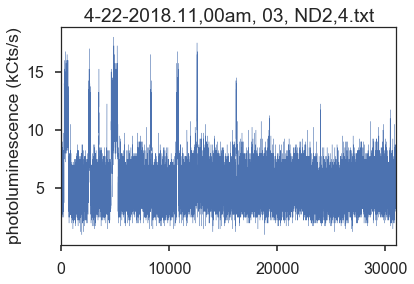

   Time (s) 2.3   2.3
0        17.252  6.50
1        17.256  9.50
2        17.260  5.00
3        17.264  6.50
4        17.268  5.25
Effective collection rate: 250.0 Hz
Time bin size: 0.004 sec


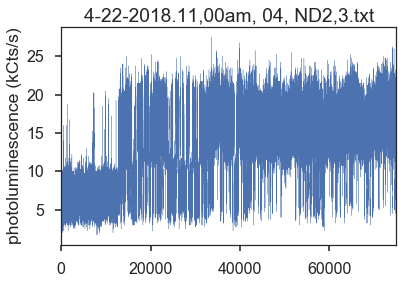

   Time (s) 2.2    2.2
0        58.088  22.75
1        58.092  21.75
2        58.096  19.25
3        58.100  21.50
4        58.104  15.50
Effective collection rate: 250.0 Hz
Time bin size: 0.004 sec


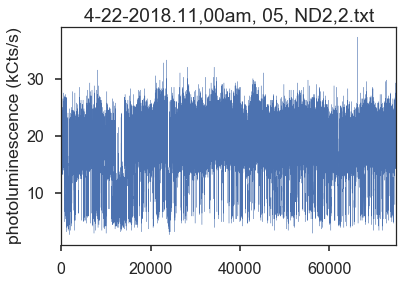

   Time (s) 2.0    2.0
0        38.860  23.50
1        38.864  22.50
2        38.868  30.50
3        38.872  24.50
4        38.876  30.75
Effective collection rate: 250.0 Hz
Time bin size: 0.004 sec


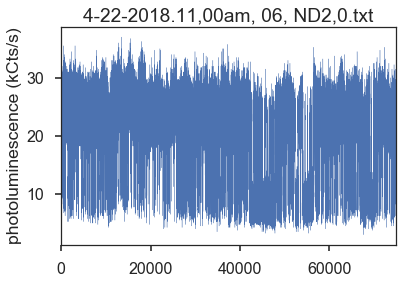

   Time (s) 1.6    1.6
0         0.008  70.50
1         0.012  66.50
2         0.016  66.75
3         0.020  73.50
4         0.024  74.50
Effective collection rate: 250.0 Hz
Time bin size: 0.004 sec


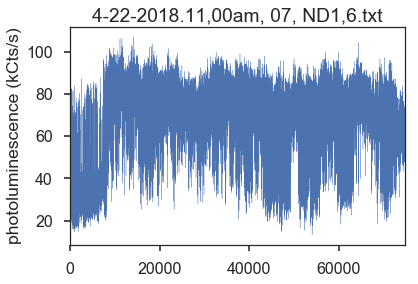

   Time (s) 1.5    1.5
0         0.008  88.00
1         0.012  88.75
2         0.016  76.50
3         0.020  81.75
4         0.024  79.50
Effective collection rate: 250.0 Hz
Time bin size: 0.004 sec


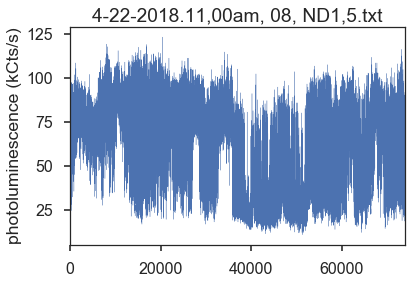

   Time (s) 1.4    1.4
0         0.002  118.0
1         0.003  106.0
2         0.004   97.0
3         0.005   89.0
4         0.006  104.0
Effective collection rate: 1000.0 Hz
Time bin size: 0.001 sec


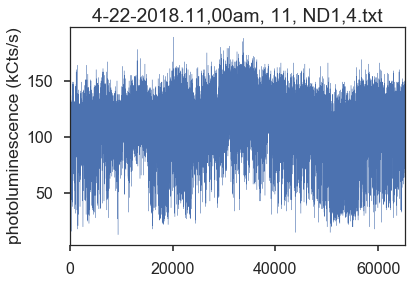

   Time (s) 1.3    1.3
0         4.602  150.0
1         4.603  136.0
2         4.604  137.0
3         4.605  124.0
4         4.606  131.0
Effective collection rate: 1000.0 Hz
Time bin size: 0.000999999999999 sec


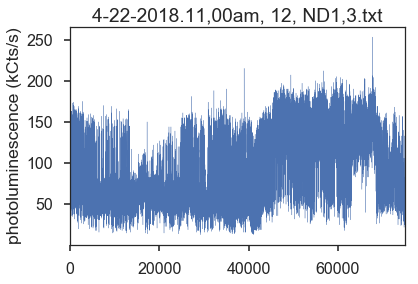

   Time (s) 1.2   1.2
0         0.002  74.0
1         0.003  80.0
2         0.004  52.0
3         0.005  86.0
4         0.006  80.0
Effective collection rate: 1000.0 Hz
Time bin size: 0.001 sec


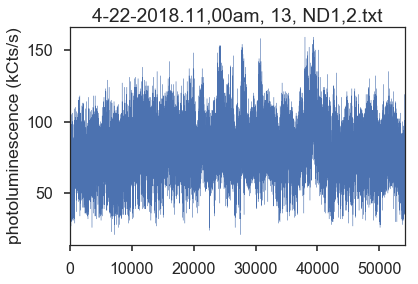

   Time (s) 1.0    1.0
0         0.002   97.0
1         0.003  132.0
2         0.004   95.0
3         0.005  112.0
4         0.006   79.0
Effective collection rate: 1000.0 Hz
Time bin size: 0.001 sec


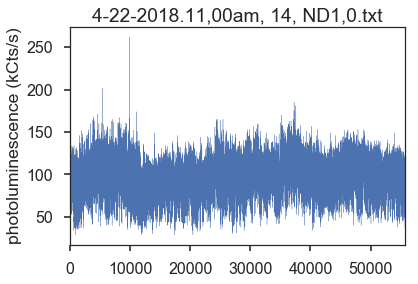

today: 2018-07-04


'C:\\Users\\Viva\\Documents\\analysis\\blinker_analysis\\power_dependence,QE4-22-2018.11,00am\\taken-2018-06-01'

In [5]:
os.chdir(datafolder)

tname = 'Time (s)'
PLname = 'PL Intensity (kCts/s)'

rebins_to_do = [0,0,0,0,0,0,0,0,0,0] # number of times to rebin. **
newfilenames = copy(filenames)
timesettings = copy(NDlist)
fps= zeros_like(NDlist)

for i in range(len(filenames)):
    data = pd.read_csv(filenames[i],
                       skiprows=1,
                       header=None,
                       sep='\t',
                       names=[tname + ' ' + str(NDlist[i]),str(NDlist[i])],
                       usecols=[0,1])
    #data = data.set_index(tname)
    print(data.head())
    rebincount = 0
    
    origfilenames = filenames
    timecolname = tname + ' ' + str(NDlist[i])
    for j in range(rebins_to_do[i]):
        data = rebindata(data, colname=str(NDlist[i]), timecolname=timecolname)
        rebincount = rebincount + 1
    timesettings[i] = data[timecolname][1]-data[timecolname][0]
    fps[i] = 1/timesettings[i]
    print('Effective collection rate: ' + str(fps[i]) + ' Hz')
    print('Time bin size: ' + str(timesettings[i]) + ' sec')
    newfilenames[i] = origfilenames[i] + ', ' + str(fps[i]) + ' Hz'

    #plt.scatter(x=data['Time (s) ' + str(NDlist[i])], y=str(NDlist[i]),linewidth=0.3)
    data[str(NDlist[i])].plot(linewidth=0.3)
    plt.ylabel('photoluminescence (kCts/s)')
    #plt.xlabel('Time(s)')
    plt.title(newfilenames[i])
    plt.show()
    
    if i > 0:
        alldata = pd.concat([alldata,data], axis=1)
    else:
        alldata = data        
 
dataname = dataname + ',no rebins'# + str(rebins_to_do) + ' rebins'
#filename = filename.replace('\\','-')
#origfilename = filename
os.chdir(analysisfolder)
today = datetime.date.isoformat(datetime.date.today())
if not os.path.exists('taken-' + datadate):
    os.makedirs('taken-' + datadate)
os.chdir('taken-' + datadate)

print('today: '+today)
os.getcwd()

In [6]:
alldata.head()

,Time (s) 2.4,2.4,Time (s) 2.3,2.3,Time (s) 2.2,2.2,Time (s) 2.0,2.0,Time (s) 1.6,1.6,Time (s) 1.5,1.5,Time (s) 1.4,1.4,Time (s) 1.3,1.3,Time (s) 1.2,1.2,Time (s) 1.0,1.0
0,0.008,5.75,17.252,6.50,58.088,22.75,38.860,23.50,0.008,70.50,0.008,88.00,0.002,118.0,4.602,150.0,0.002,74.0,0.002,97.0
1,0.012,6.25,17.256,9.50,58.092,21.75,38.864,22.50,0.012,66.50,0.012,88.75,0.003,106.0,4.603,136.0,0.003,80.0,0.003,132.0
2,0.016,5.50,17.260,5.00,58.096,19.25,38.868,30.50,0.016,66.75,0.016,76.50,0.004,97.0,4.604,137.0,0.004,52.0,0.004,95.0
3,0.020,5.75,17.264,6.50,58.100,21.50,38.872,24.50,0.020,73.50,0.020,81.75,0.005,89.0,4.605,124.0,0.005,86.0,0.005,112.0
4,0.024,6.25,17.268,5.25,58.104,15.50,38.876,30.75,0.024,74.50,0.024,79.50,0.006,104.0,4.606,131.0,0.006,80.0,0.006,79.0


In [7]:
alldata.tail()

,Time (s) 2.4,2.4,Time (s) 2.3,2.3,Time (s) 2.2,2.2,Time (s) 2.0,2.0,Time (s) 1.6,1.6,Time (s) 1.5,1.5,Time (s) 1.4,1.4,Time (s) 1.3,1.3,Time (s) 1.2,1.2,Time (s) 1.0,1.0
74994,NaN,NaN,317.228,19.75,358.064,20.50,338.836,25.75,NaN,NaN,NaN,NaN,NaN,NaN,79.596,28.0,NaN,NaN,NaN,NaN
74995,NaN,NaN,317.232,13.00,358.068,20.00,338.840,20.00,NaN,NaN,NaN,NaN,NaN,NaN,79.597,28.0,NaN,NaN,NaN,NaN
74996,NaN,NaN,317.236,20.25,358.072,14.75,338.844,22.00,NaN,NaN,NaN,NaN,NaN,NaN,79.598,30.0,NaN,NaN,NaN,NaN
74997,NaN,NaN,317.240,11.75,358.076,19.75,338.848,21.50,NaN,NaN,NaN,NaN,NaN,NaN,79.599,35.0,NaN,NaN,NaN,NaN
74998,NaN,NaN,317.244,14.00,358.080,18.50,338.852,23.75,NaN,NaN,NaN,NaN,NaN,NaN,79.600,25.0,NaN,NaN,NaN,NaN


In [8]:
strNDlist = []
for ND in NDlist:
    strNDlist.append(str(ND))
data = alldata[strNDlist]
data.head()

,2.4,2.3,2.2,2.0,1.6,1.5,1.4,1.3,1.2,1.0
0,5.75,6.50,22.75,23.50,70.50,88.00,118.0,150.0,74.0,97.0
1,6.25,9.50,21.75,22.50,66.50,88.75,106.0,136.0,80.0,132.0
2,5.50,5.00,19.25,30.50,66.75,76.50,97.0,137.0,52.0,95.0
3,5.75,6.50,21.50,24.50,73.50,81.75,89.0,124.0,86.0,112.0
4,6.25,5.25,15.50,30.75,74.50,79.50,104.0,131.0,80.0,79.0


In [9]:
strNDlist

['2.4', '2.3', '2.2', '2.0', '1.6', '1.5', '1.4', '1.3', '1.2', '1.0']

In [10]:
print max(data.max())
print min(data.min())

262.0
1.0


histdata initialized


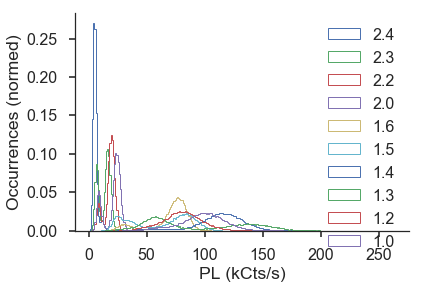

In [11]:
stepsize = 1
# adding a stepsize to the max is a workaround to a bug
binsequence= frange(min(data.min()),max(data.max())+stepsize,stepsize)

try:
    del histdata
except NameError:
    pass
#histdata=pd.DataFrame(columns=['ND', PLname, "Occurrences"])

histdict = []
for i in range(len(strNDlist)):
    plt.hist(data[strNDlist[i]], bins=binsequence,  histtype='step', linewidth=1, label=strNDlist[i], normed=True)
    newhistdata, toss = histc(data[strNDlist[i]], bins=np.asarray(binsequence))
    NDlisttemp = [NDlist[i]] * len(binsequence)
    ## Norm the newhistdata
    #   adding a stepsize to the max was a workaround to a bug
    #   now we remove that last bin, which should have been empty (but it's so buggy it wasn't empty)
    newhistdatanormed = manualnorm(newhistdata[:-1], stepsize)
    
    try:
        # append histogram to dataframe histdata

        histdata = histdata.append(pd.DataFrame(transpose([NDlisttemp[:-1], binsequence[:-1],newhistdatanormed.tolist()])))
#        print "appended"
    except NameError:
        histdata = pd.DataFrame(transpose([NDlisttemp[:-1], binsequence[:-1],newhistdatanormed.tolist()]))
        print "histdata initialized"
histdata = histdata.rename(index=str, columns={0: 'ND', 1: PLname, 2:"Probability"})           
tabledata = histdata.pivot("ND", PLname, "Probability")

# In terms of laser intensity instead of optical density
powertabledata = tabledata.join(filterwheel.set_index('ND')).set_index('Power (W)')

#sns.distplot(data[strNDlist[9]], bins=numbins, kde=True, rug=False, hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "color": "k"});
plt.xlabel('PL (kCts/s)')
plt.ylabel('Occurrences (normed)')
#ax = plt.gca()
#ax.set_yscale('symlog', linthreshy=1)
#ax.set_xscale('log')
sns.despine()
plt.legend()
plt.show()


In [12]:
NDlist

[2.4, 2.3, 2.2, 2.0, 1.6, 1.5, 1.4, 1.3, 1.2, 1.0]

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


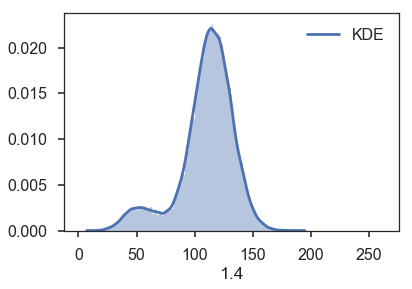

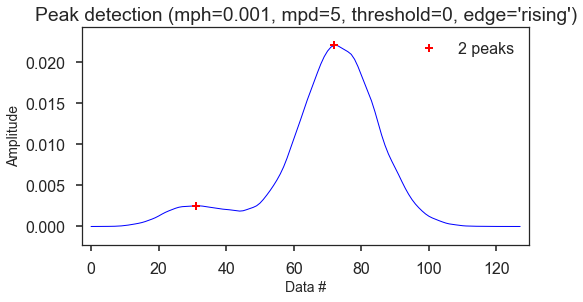

array([  52.88976378,  113.58267717])

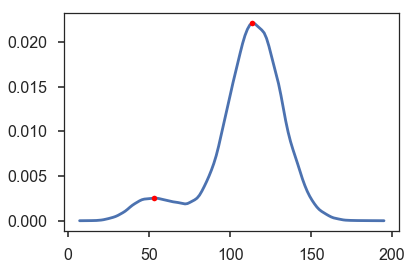

In [13]:
## I want to extract the peaks of these data
# https://stackoverflow.com/questions/37374983/get-data-points-from-seaborn-distplot

i = 6

# bw = bandwidth for calculating kde
bw = 2
# mph = minimum peak height
mph = .001
# mpd = minimum peak distance
mpd = 5

plt.figure()
output1 = sns.distplot(data[strNDlist[i]],bins=binsequence,kde_kws={'bw':bw, 'label':'KDE'},).get_lines()[0].get_data()

## http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb



ind= detect_peaks(output1[1], valley=False, show=True, mph=mph, mpd=mpd)
#print ind

figure()
plot(output1[0], output1[1])
plot(output1[0][ind], output1[1][ind], 'r.')
output1[0][ind]

today: 2018-07-04
C:\Users\Viva\Documents\analysis\blinker_analysis\power_dependence,QE4-22-2018.11,00am\taken-2018-06-01
0: 2.4
1: 2.3
2: 2.2
3: 2.0
4: 1.6
5: 1.5
6: 1.4
7: 1.3
8: 1.2
9: 1.0


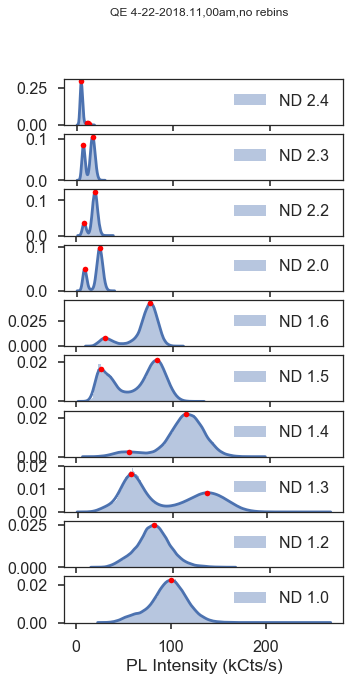

In [14]:
os.chdir(analysisfolder)
today = datetime.date.isoformat(datetime.date.today())
if not os.path.exists('taken-' + datadate):
    os.makedirs('taken-' + datadate)
os.chdir('taken-' + datadate)

print('today: '+today)
print os.getcwd()

peaksPL = {NDlist[0]:None}
peaksprob = {NDlist[0]:None}

plt.figure(figsize=(5,10))
title(dataname)
for i in range(len(strNDlist)):
    print str(i) + ': ' + strNDlist[i]
    ax = plt.subplot(len(strNDlist), 1, i+1)
    # Calculate and plot histograms
    output = sns.distplot(data[strNDlist[i]],
                          bins=binsequence, 
        #                  kde_kws={'bw':bw},
                          label='ND ' + strNDlist[i],).get_lines()[0].get_data()
    ind= detect_peaks(output[1], valley=False, show=False, mph=mph, mpd=mpd)
    ax.plot(output[0][ind], output[1][ind], 'r.')
    # record these peaks
    peaksPL[NDlist[i]] = output[0][ind]
    peaksprob[NDlist[i]] =output[1][ind]
    legend()

xlabel(PLname);

suptitle(dataname)
plt.savefig(today + ',' + dataname+',PLvspowerhists.pdf', bbox_inches='tight')
plt.savefig(today + ',' + dataname+',PLvspowerhists.png', bbox_inches='tight', dpi=200)

0: 2.4
1: 2.3
2: 2.2
3: 2.0
4: 1.6
5: 1.5
6: 1.4
Made ylabel
7: 1.3
8: 1.2
9: 1.0


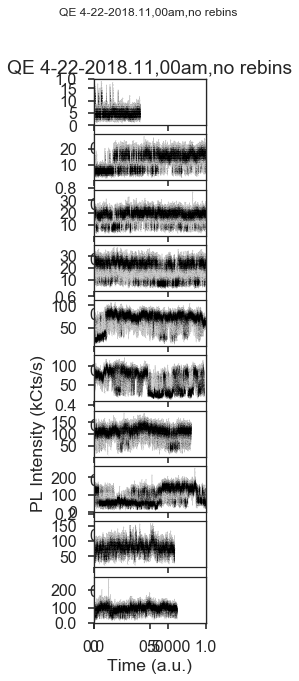

In [15]:
fig = plt.figure(figsize=(2,10))
title(dataname)
made_ylabel = False
for i in range(len(strNDlist)):
    print str(i) + ': ' + strNDlist[i]
    ax = fig.add_subplot(len(strNDlist), 1, i+1)
    thisdata = data[strNDlist[i]]
    thisdata.plot(marker='.', markersize=1,linestyle='None',legend=False, ax=ax, color='k',  alpha=.1)
    thisdata.plot(legend=False, linewidth=0.5, alpha=0.2, ax=ax, color='k')
    #legend()
    
    if made_ylabel == False:
        if i > 0.5 * len(strNDlist):
            ylabel(PLname)
            print('Made ylabel')
            made_ylabel = True

xlabel('Time (a.u.)');
suptitle(dataname);

In [16]:
peaksPL

{1.0: array([ 100.03451628]),
 1.2: array([ 79.97967727]),
 1.3: array([  55.84951855,  136.17056773]),
 1.4: array([  54.16516655,  113.63797093]),
 1.5: array([ 25.54601706,  83.03794409]),
 1.6: array([ 29.55918383,  76.59186316]),
 2.0: array([  8.51729257,  23.82756914]),
 2.2: array([  8.24229729,  19.27421588]),
 2.3: array([  6.71068463,  16.11610289]),
 2.4: array([  4.740932  ,  10.84958645,  11.70195683,  12.98051241])}

In [17]:
peaksprob

{1.0: array([ 0.02264876]),
 1.2: array([ 0.02482748]),
 1.3: array([ 0.01628588,  0.00833352]),
 1.4: array([ 0.00251575,  0.02206175]),
 1.5: array([ 0.01662159,  0.02095669]),
 1.6: array([ 0.00791638,  0.0422979 ]),
 2.0: array([ 0.04900305,  0.0977245 ]),
 2.2: array([ 0.03641481,  0.12472405]),
 2.3: array([ 0.08430656,  0.10437797]),
 2.4: array([ 0.29697944,  0.01198245,  0.01242233,  0.00740431])}

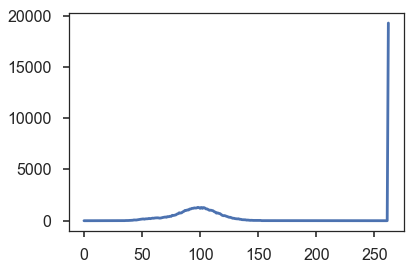

In [18]:
# The bug!
plot(newhistdata);

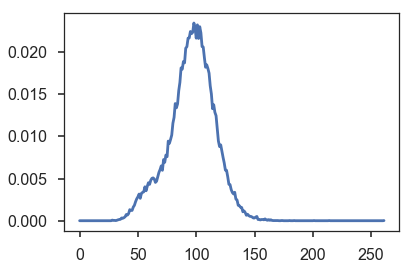

In [19]:
# Dealt with the bug!
plot(newhistdatanormed);

In [20]:
histdata.head()

,ND,PL Intensity (kCts/s),Probability
0,2.4,1.0,0.002258
1,2.4,2.0,0.032935
2,2.4,3.0,0.145032
3,2.4,4.0,0.269710
4,2.4,5.0,0.262871


In [21]:
NDlist

[2.4, 2.3, 2.2, 2.0, 1.6, 1.5, 1.4, 1.3, 1.2, 1.0]

In [22]:
powlist = []
for ND in NDlist:
    powlist.append(filterwheel.loc[filterwheel['ND']==ND]['Power (W)'].values[0]) 

powlist

[2.7399999999999995e-05,
 3.8299999999999996e-05,
 4.7899999999999999e-05,
 7.0599999999999995e-05,
 0.00022499999999999999,
 0.00030600000000000001,
 0.000377,
 0.00054800000000000009,
 0.00064000000000000005,
 0.00099500000000000001]

In [23]:
#filterwheel.set_index('ND')

# previously made NDlistwrap manually
"""
NDlistwrap = [2.45, 2.35, 2.25, (2.2+2.0)/2, (2.0+1.6)/2, 1.55, 1.45, 1.35, 1.25, (1.2+1.0)/2, 1.0-0.05]

NDlistwrap[::-1]
"""

'\nNDlistwrap = [2.45, 2.35, 2.25, (2.2+2.0)/2, (2.0+1.6)/2, 1.55, 1.45, 1.35, 1.25, (1.2+1.0)/2, 1.0-0.05]\n\nNDlistwrap[::-1]\n'

In [24]:
# create a listwrap that wraps around the list 
# This is what I need for pcolormesh.
def listwrap(currentlist):
    listwrap = [0] * (len(currentlist)+1)
    for i in range(len(currentlist)):
        try:
            listwrap[i+1] = ((currentlist[i]+currentlist[i+1])/2)
        except IndexError:
            pass
    topstep = listwrap[2]-listwrap[1]
    listwrap[0]=listwrap[1]-topstep
    botstep = listwrap[-2]-listwrap[-3]
    listwrap[-1]=listwrap[-2]+botstep
    return listwrap

In [25]:
NDlistwrap = listwrap(NDlist)
NDlistwrap[::-1]

[0.9500000000000002,
 1.1,
 1.25,
 1.35,
 1.45,
 1.55,
 1.8,
 2.1,
 2.25,
 2.3499999999999996,
 2.4499999999999993]

In [26]:
tabledata

PL Intensity (kCts/s),1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,253.0,254.0,255.0,256.0,257.0,258.0,259.0,260.0,261.0,262.0
ND,,,,,,,,,,,,,,,,,,,,,
1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000018
1.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1.4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000014,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2.0,0.000000,0.000000,0.000227,0.002560,0.011587,0.029307,0.046827,0.052094,0.046907,0.031960,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2.2,0.000000,0.000027,0.000480,0.002187,0.009013,0.020107,0.031040,0.036214,0.030974,0.020774,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2.3,0.000027,0.000720,0.006573,0.027907,0.063588,0.087001,0.078334,0.052627,0.025987,0.013960,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [27]:
peaksPL

{1.0: array([ 100.03451628]),
 1.2: array([ 79.97967727]),
 1.3: array([  55.84951855,  136.17056773]),
 1.4: array([  54.16516655,  113.63797093]),
 1.5: array([ 25.54601706,  83.03794409]),
 1.6: array([ 29.55918383,  76.59186316]),
 2.0: array([  8.51729257,  23.82756914]),
 2.2: array([  8.24229729,  19.27421588]),
 2.3: array([  6.71068463,  16.11610289]),
 2.4: array([  4.740932  ,  10.84958645,  11.70195683,  12.98051241])}

In [28]:
peaksPL.get(2.4)

array([  4.740932  ,  10.84958645,  11.70195683,  12.98051241])

Text(0.5,0,u'ND')

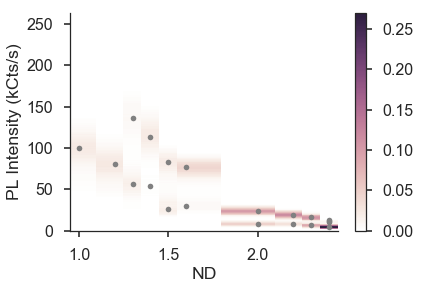

In [29]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
#cmap = sns.color_palette("Grey", as_cmap=True)

plt.figure(figsize=(6,4))
plt.pcolormesh(NDlistwrap[::-1], binsequence, transpose(tabledata), cmap=cmap)
sns.despine()
colorbar()

for i in range(len(NDlist)):
    plot([NDlist[i]]*len(peaksPL.get(NDlist[i])),peaksPL.get(NDlist[i]), '.', color='grey')

ylim(ymin=0)
plt.ylabel(PLname)
plt.xlabel('ND')

In [30]:
powlist

[2.7399999999999995e-05,
 3.8299999999999996e-05,
 4.7899999999999999e-05,
 7.0599999999999995e-05,
 0.00022499999999999999,
 0.00030600000000000001,
 0.000377,
 0.00054800000000000009,
 0.00064000000000000005,
 0.00099500000000000001]

In [31]:
powlistwrap = listwrap(powlist)
powlistwrap

[2.26e-05,
 3.2849999999999999e-05,
 4.3099999999999997e-05,
 5.9249999999999997e-05,
 0.00014779999999999999,
 0.0002655,
 0.00034150000000000001,
 0.00046250000000000002,
 0.00059400000000000013,
 0.00081750000000000008,
 0.001041]

In [32]:
lowerpeaks = np.zeros_like(NDlist)
keepgoing = [False] * len(NDlist)
for i in range(len(NDlist)):
#    print peaksPL.get(NDlist[i]).min()
    lowerpeaks[i] = peaksPL.get(NDlist[i]).min()
    # set keepgoign to true if there  is still another value
lowerpeaks

array([   4.740932  ,    6.71068463,    8.24229729,    8.51729257,
         29.55918383,   25.54601706,   54.16516655,   55.84951855,
         79.97967727,  100.03451628])

In [33]:
#collect the upperpeaks

upperpeaks = np.zeros_like(NDlist)
for i in range(len(NDlist)):
#    print peaksPL.get(NDlist[i]).min()
    upperpeaks[i] = peaksPL.get(NDlist[i]).max()
    # set keepgoign to true if there  is still another value
# *** not quite automated
upperpeaks = upperpeaks[:-2]
powlistforupperpeaks = powlist[:-2]
upperpeaks

array([  12.98051241,   16.11610289,   19.27421588,   23.82756914,
         76.59186316,   83.03794409,  113.63797093,  136.17056773])

In [34]:
from scipy.optimize import curve_fit
import scipy
print(scipy.__version__)
# need at least version 14.0 of scipy.

def expfit(t, A, tau):
    return (A * np.exp(t/(-tau)))

def powlaw(t, C, m):
    return C * t**(-m)

# laser power P, saturation power Psat
def satcurve(P,Psat,signalmax):
    return signalmax/(1 + Psat/P)

0.17.1


In [35]:
powlist

[2.7399999999999995e-05,
 3.8299999999999996e-05,
 4.7899999999999999e-05,
 7.0599999999999995e-05,
 0.00022499999999999999,
 0.00030600000000000001,
 0.000377,
 0.00054800000000000009,
 0.00064000000000000005,
 0.00099500000000000001]

Lower peaks saturation at 0.00320679611786 +/- 0.00242603064202 W
Upper peaks saturation at 0.000877062971108 +/- 0.000269845544551 W


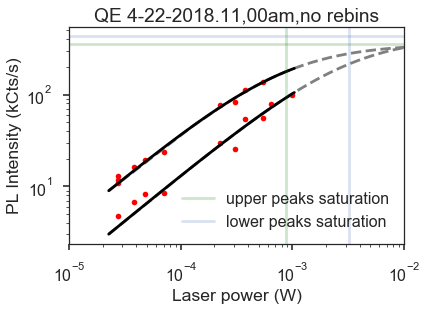

In [36]:
x = np.linspace(start = min(powlistwrap), stop = max(powlistwrap),num =100)
x_extended = np.linspace(start = min(powlistwrap), stop = 30*max(powlistwrap),num =300)

# curvefit
lowerpeaksparam, lowerpeakspcov = curve_fit(satcurve, xdata=powlist, ydata=lowerpeaks,p0 = None)
lowerpeaksfit = satcurve(x,lowerpeaksparam[0],lowerpeaksparam[1])
lowerpeaksfitextended = satcurve(x_extended,lowerpeaksparam[0],lowerpeaksparam[1])

print 'Lower peaks saturation at ' + str(lowerpeaksparam[0]) + ' +/- ' + str(np.sqrt(lowerpeakspcov[0,0])) + ' W'

# curvefit upperpeaks
upperpeaksparam, upperpeakspcov = curve_fit(satcurve, xdata=powlistforupperpeaks, ydata=upperpeaks,p0 = None)
upperpeaksfit = satcurve(x,upperpeaksparam[0],upperpeaksparam[1])
upperpeaksfitextended = satcurve(x_extended,upperpeaksparam[0],upperpeaksparam[1])

print 'Upper peaks saturation at ' + str(upperpeaksparam[0]) + ' +/- ' + str(np.sqrt(upperpeakspcov[0,0])) + ' W'


figure(figsize=(6,4))
for i in range(len(NDlist)):
    plot([powlist[i]]*len(peaksPL.get(NDlist[i])),peaksPL.get(NDlist[i]), '.', color='r') # plot peaks
plot(x_extended,lowerpeaksfitextended, '--', color='grey') # plot curvefit out a bit further
plot(x,lowerpeaksfit, 'k') # plot curvefit where I actually did the curvefit.
plot(x_extended,upperpeaksfitextended, '--', color='grey') # plot curvefit out a bit further
plot(x,upperpeaksfit, 'k') # plot curvefit where I actually did the curvefit.
xlabel('Laser power (W)')
ylabel(PLname)
plt.axvline(upperpeaksparam[0], label="upper peaks saturation", color='g', alpha=.2)
plt.axvline(lowerpeaksparam[0], label="lower peaks saturation", alpha=.2)
plt.axhline(upperpeaksparam[1], color='g', alpha=.2)
plt.axhline(lowerpeaksparam[1], alpha=.2)


ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
title(dataname)
xlim(1e-5,xmax=1e-2)

legend();

In [37]:
lowerpeaksparam[0] - np.sqrt(lowerpeakspcov[0,0])

0.00078076547583605122

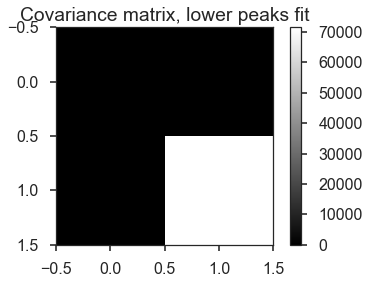

It's ok to use the uncertainties as long as there aren't strong off-diagonal values.


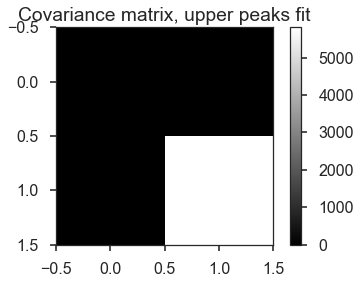

It's ok to use the uncertainties as long as there aren't strong off-diagonal values.


In [38]:
plt.imshow(abs(lowerpeakspcov), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, lower peaks fit')
plt.show()
print("It's ok to use the uncertainties as long as there aren't strong off-diagonal values.")

plt.imshow(abs(upperpeakspcov), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, upper peaks fit')
plt.show()
print("It's ok to use the uncertainties as long as there aren't strong off-diagonal values.")

In [39]:
NDlist

[2.4, 2.3, 2.2, 2.0, 1.6, 1.5, 1.4, 1.3, 1.2, 1.0]

In [40]:
peaksPL

{1.0: array([ 100.03451628]),
 1.2: array([ 79.97967727]),
 1.3: array([  55.84951855,  136.17056773]),
 1.4: array([  54.16516655,  113.63797093]),
 1.5: array([ 25.54601706,  83.03794409]),
 1.6: array([ 29.55918383,  76.59186316]),
 2.0: array([  8.51729257,  23.82756914]),
 2.2: array([  8.24229729,  19.27421588]),
 2.3: array([  6.71068463,  16.11610289]),
 2.4: array([  4.740932  ,  10.84958645,  11.70195683,  12.98051241])}

today: 2018-07-04
C:\Users\Viva\Documents\analysis\blinker_analysis\power_dependence,QE4-22-2018.11,00am\taken-2018-06-01
Lower peaks saturation at 3206.79611786 ± 0.00242603064202 μW
Upper peaks saturation at 877.062971108 ± 0.000269845544551 μW
2018-07-04,QE 4-22-2018.11,00am,no rebins,doublesaturationcurve


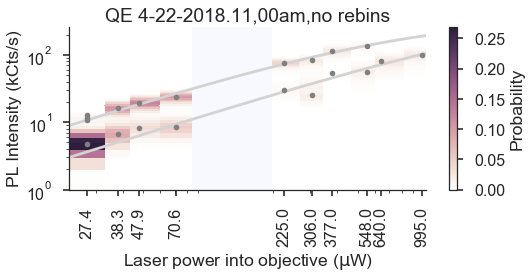

In [41]:
os.chdir(analysisfolder)
today = datetime.date.isoformat(datetime.date.today())
if not os.path.exists('taken-' + datadate):
    os.makedirs('taken-' + datadate)
os.chdir('taken-' + datadate)

print('today: '+today)
print os.getcwd()

#cmap = sns.cubehelix_palette(n_colors = 1, start=0, rot=1, light=1, as_cmap=True)
cmap = sns.cubehelix_palette( light=1, as_cmap=True)
#cmap = sns.color_palette("Grey", as_cmap=True)

figure(figsize=(8,3))
plt.pcolormesh(powlistwrap[::-1],  binsequence, transpose(powertabledata), cmap=cmap)
sns.despine()
cbar = colorbar(drawedges=False)
cbar.set_label('Probability')



#ylim(ymin=0)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

xticks(powlist, [power*1000*1000 for power in powlist],rotation='vertical')
#xticks(powlist, [pow for pow in powlist],rotation='vertical')

plt.ylabel(PLname)
plt.xlabel('Laser power into objective ($\mathrm{\mu}$W)')
#plt.xlabel('Laser power into objective (W)')
title(dataname)


# Cover section that has no data
plt.axvline(x=1.3e-4, linewidth=80, color='ghostwhite')

# plot curvefits
plot(x,lowerpeaksfit, '-', color='lightgrey')
plot(x,upperpeaksfit, '-', color='lightgrey') 

# plot points at the peaks
for i in range(len(NDlist)):
    plot([powlist[i]]*len(peaksPL.get(NDlist[i])),peaksPL.get(NDlist[i]), '.', color='grey')

print('Lower peaks saturation at ' + str(lowerpeaksparam[0]*1000*1000)
      + ' ± ' + str(np.sqrt(lowerpeakspcov[0,0])) + ' μW')
print('Upper peaks saturation at ' + str(upperpeaksparam[0]*1000*1000)
      + ' ± ' + str(np.sqrt(upperpeakspcov[0,0])) + ' μW')

#savefig
plt.savefig(today + ',' + dataname+',doublesaturationcurve.pdf', bbox_inches='tight')
plt.savefig(today + ',' + dataname+',doublesaturationcurve.png', bbox_inches='tight', dpi=200)
print(today + ',' + dataname+',doublesaturationcurve')

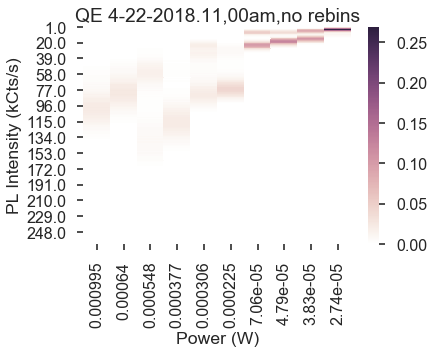

In [42]:
## The heatmap isn't as customizable but it's more automated 
## so it's a good check that I entered in the variables correctly.
sns.heatmap(transpose(powertabledata), cmap = cmap)
ylabel(PLname)
title(dataname)

## decrease number of ticks on x axis.
ax = plt.gca()
#ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
#ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

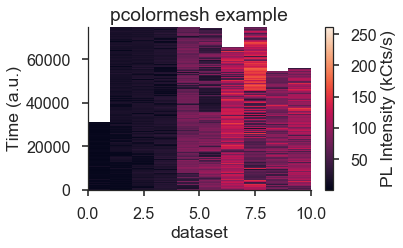

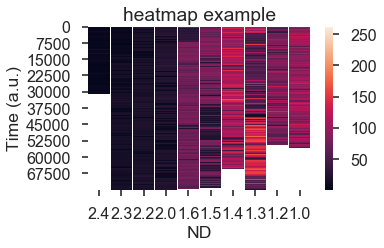

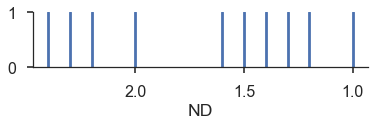

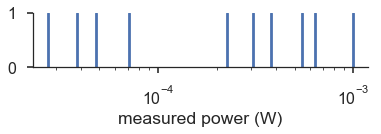

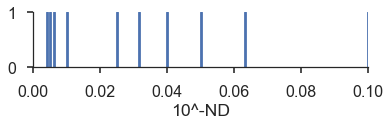

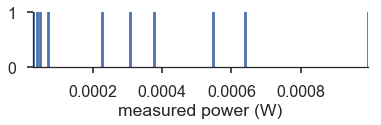

In [43]:
## This cell doesn't have to be run. Just some thoughts about the data system.

figure(figsize(5,3))
plt.pcolormesh(data)
sns.despine()

cbar =colorbar()
cbar.set_label(PLname)
title('pcolormesh example')
ylabel('Time (a.u.)')
xlabel('dataset')
plt.show()

figure()
sns.heatmap(data, linewidths=0)
title('heatmap example')
ylabel('Time (a.u.)')
xlabel('ND')


# https://stackoverflow.com/questions/49020709/seaborn-heatmap-with-numerical-axes
# You cannot "convince" heatmap not to produce a categorical plot. 
# Best use another image plot, which uses numerical axes. For example, use a pcolormesh plot. 
# The assumption is of course that the columns and rows are equally spread. 


## Some thoughts about figure spacing
plt.figure(figsize(6,1))
for ND in NDlist:
    plt.axvline(x=ND)
sns.despine()
xlabel('ND')
plt.gca().invert_xaxis()
    
plt.figure()
for thispower in powlist:
   # print thispower
    plt.axvline(x=thispower)
#plt.xlim(xmin=min(powlist), xmax = max(powlist))
sns.despine()
ax = plt.gca()
ax.set_xscale('log')
xlabel('measured power (W)' )    
    
plt.figure()
for ND in NDlist:
    plt.axvline(x=10**-ND)
plt.xlim(xmax=10**-min(NDlist))   
sns.despine()
xlabel('10^-ND')

plt.figure()
for thispower in powlist:
  #  print thispower
    plt.axvline(x=thispower)
plt.xlim(xmin=min(powlist), xmax = max(powlist))
sns.despine()
xlabel('measured power (W)' )




plt.show()